## Introdução e o Dataset   
   O dataset utilizado neste exercício foi o dataset Previsão de Segurança do Motorista, disponibilizado pela Porto Seguro. Há um desbalanceamento na classe de saída e vamos descobrir como lidar com esse tipo de dado.
    Em um primeiro momento, devemos fazer a análise exploratória dos dados.
    
#### About this Dataset

#### Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

#### File descriptions
- train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- test.csv contains the test data.
- sample_submission.csv is submission file showing the correct format.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [5]:
train=pd.read_csv('../data/porto-seguro/train.csv', na_values=-1)
test=pd.read_csv('../data/porto-seguro/test.csv', na_values=-1)

In [6]:
train.isnull().values.any()

True

In [7]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

In [10]:
train.shape

(595212, 59)

In [9]:
train.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat     float64
ps_ind_03           int64
ps_ind_04_cat     float64
ps_ind_05_cat     float64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat     float64
ps_car_02_cat     float64
ps_car_03_cat     float64
ps_car_04_cat       int64
ps_car_05_cat     float64
ps_car_06_cat       int64
ps_car_07_cat     float64
ps_car_08_cat       int64
ps_car_09_cat     float64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [14]:
describe = train.describe().T
describe['reg'] = (describe['50%'] - describe['mean'])/(describe['max']-describe['min'])

In [15]:
describe

,count,mean,std,min,25%,50%,75%,max,reg
id,595212.0,743803.558435,429367.820429,7.000000,371991.500000,743547.500000,1.115549e+06,1.488027e+06,-0.000172
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,-0.036448
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000e+00,7.000000e+00,-0.128625
ps_ind_02_cat,594996.0,1.359799,0.663193,1.000000,1.000000,1.000000,2.000000e+00,4.000000e+00,-0.119933
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000e+00,1.100000e+01,-0.038483
ps_ind_04_cat,595129.0,0.416992,0.493062,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,-0.416992
ps_ind_05_cat,589403.0,0.419038,1.350023,0.000000,0.000000,0.000000,0.000000e+00,6.000000e+00,-0.069840
ps_ind_06_bin,595212.0,0.393742,0.488579,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,-0.393742
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,-0.257033
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,-0.163921


In [22]:
data_corr = train.corr()['target'].sort_values(ascending=False)
data_corr

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038800
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_reg_03         0.033758
ps_car_04_cat     0.032900
ps_ind_05_cat     0.032254
ps_car_15         0.027667
ps_reg_01         0.022888
ps_car_03_cat     0.020729
ps_ind_01         0.018570
ps_car_01_cat     0.017290
ps_ind_08_bin     0.013147
ps_car_14         0.011674
ps_car_06_cat     0.011537
ps_ind_04_cat     0.010146
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_11_cat     0.006129
ps_car_09_cat     0.006013
ps_ind_02_cat     0.005574
ps_ind_18_bin     0.004555
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_car_05_cat     0.000871
ps_calc_05        0.000771
ps_calc_09        0.000719
p

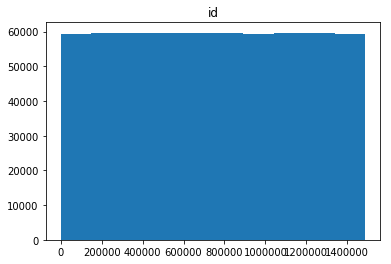

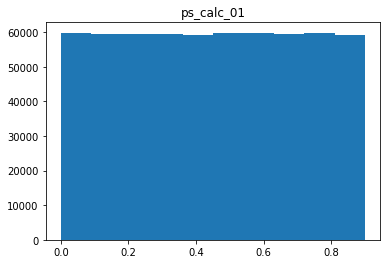

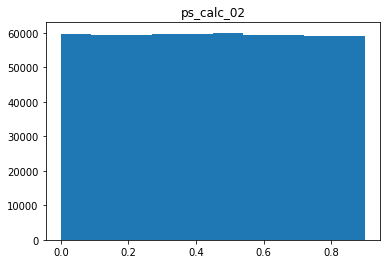

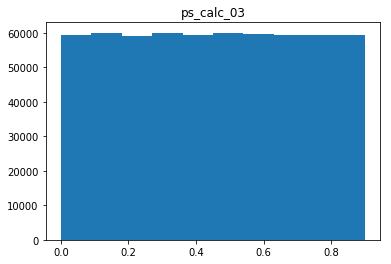

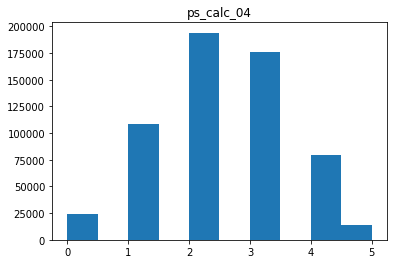

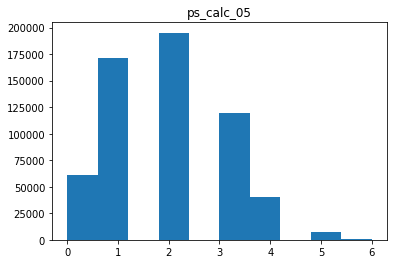

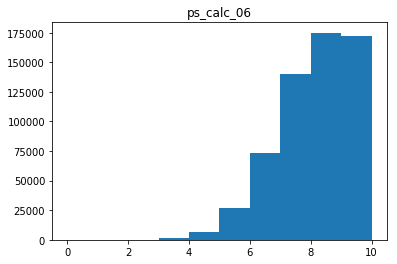

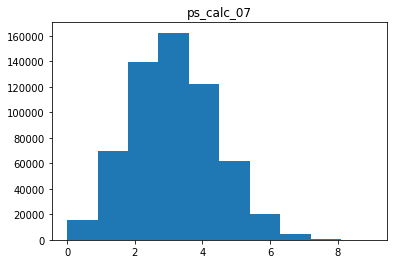

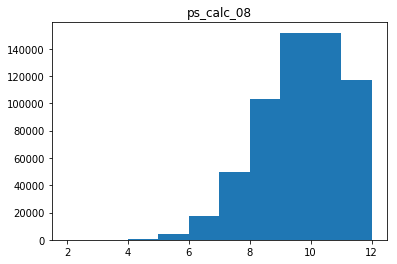

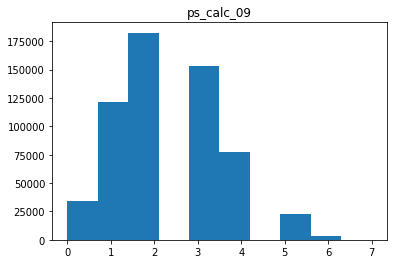

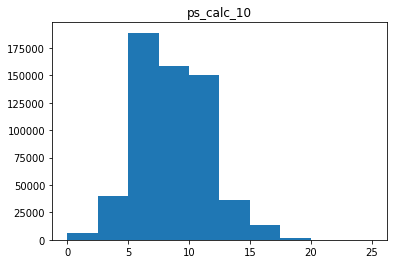

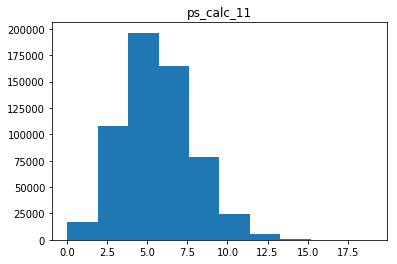

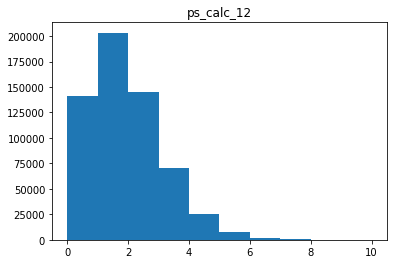

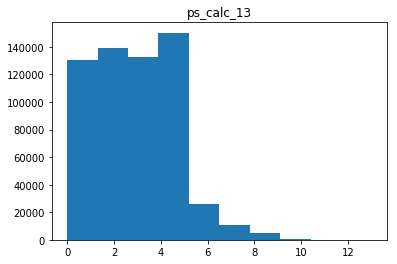

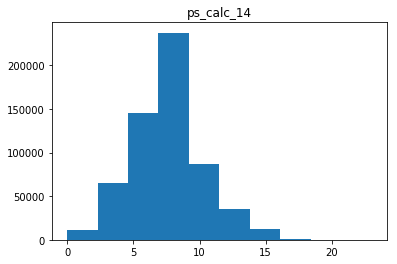

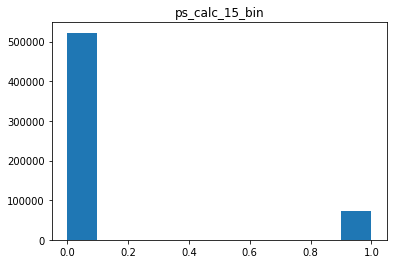

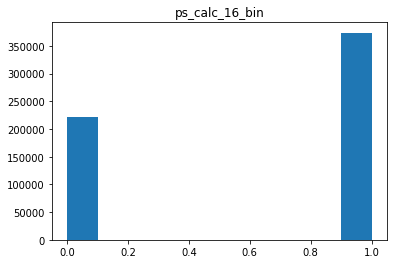

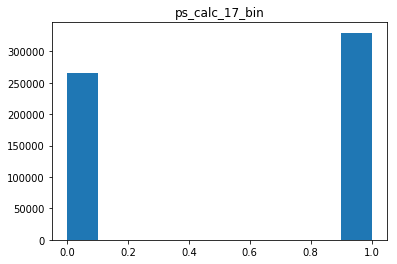

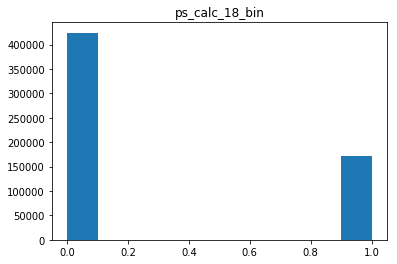

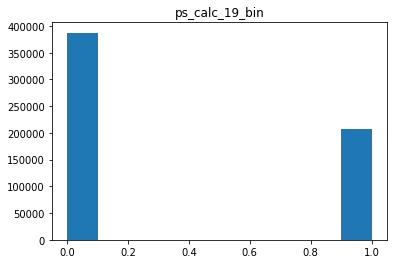

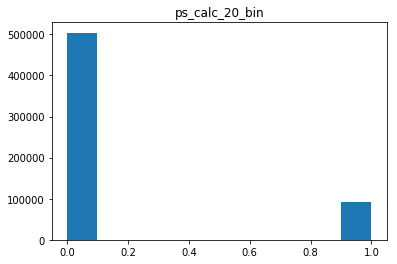

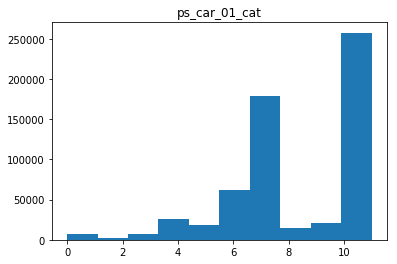

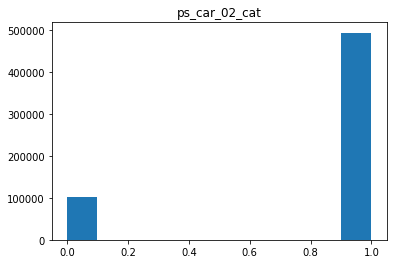

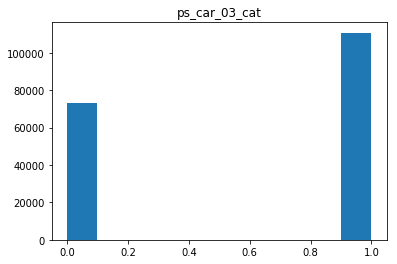

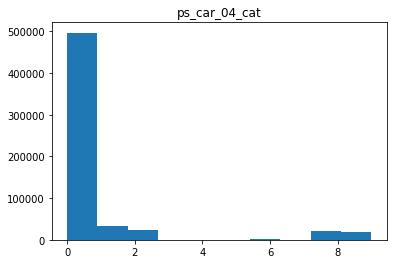

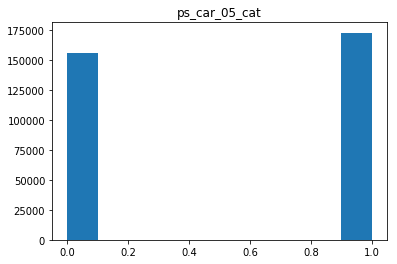

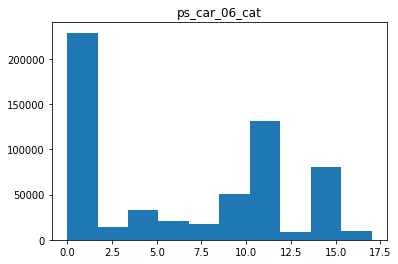

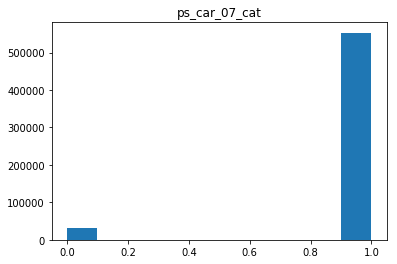

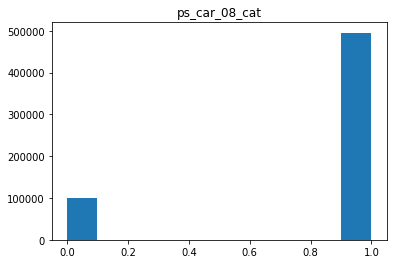

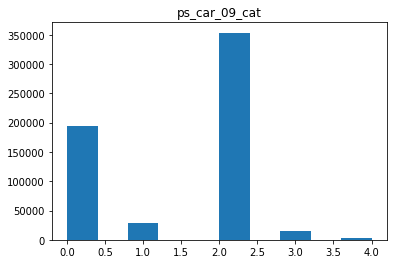

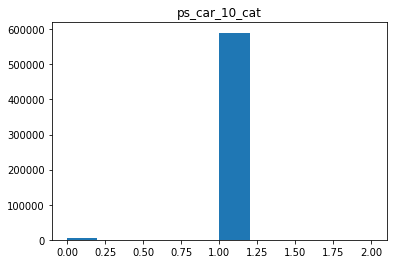

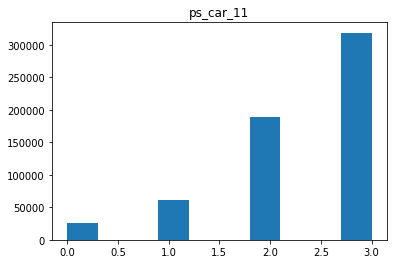

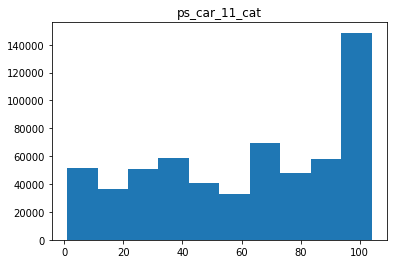

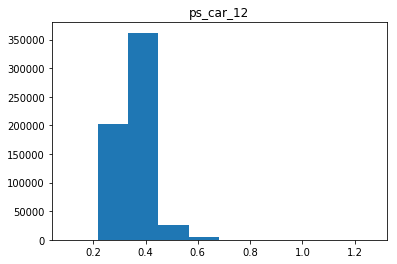

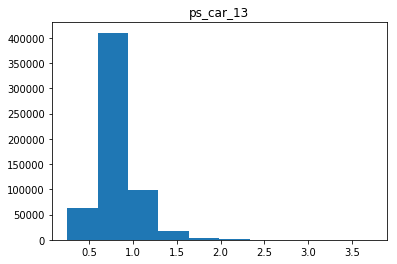

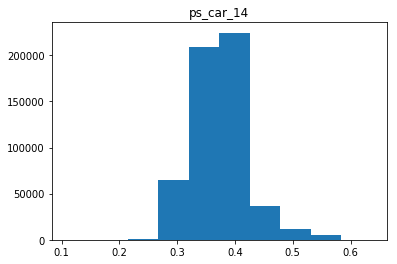

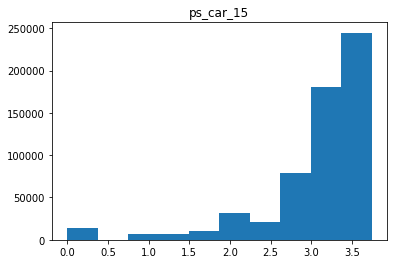

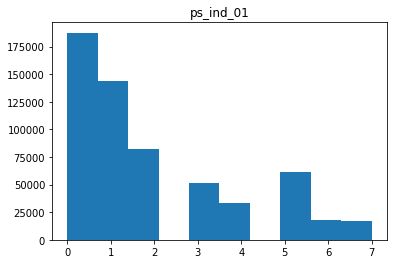

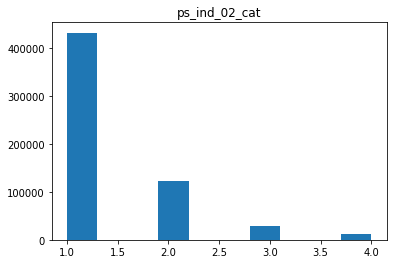

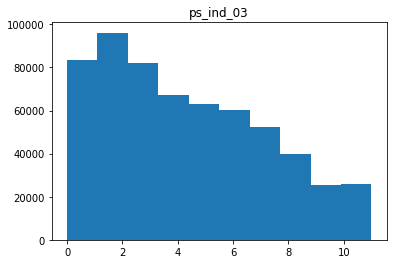

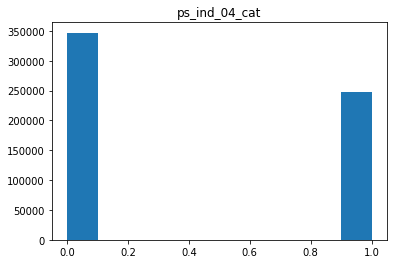

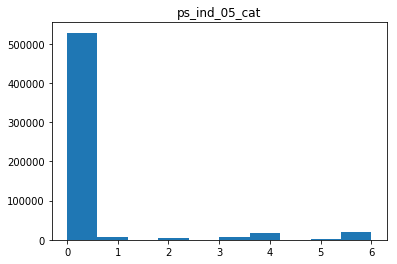

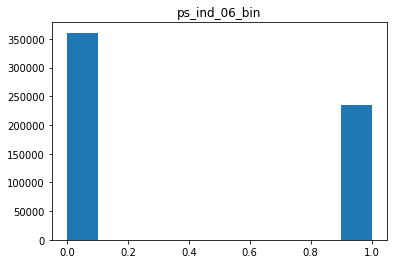

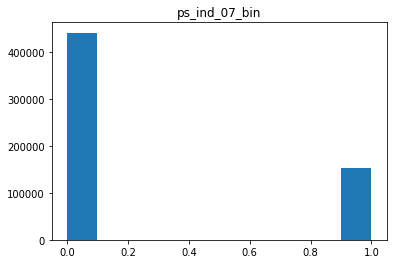

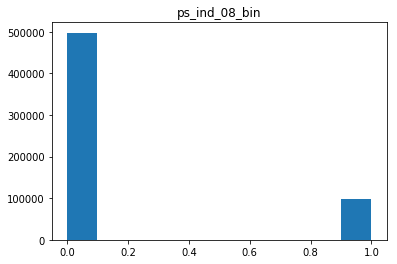

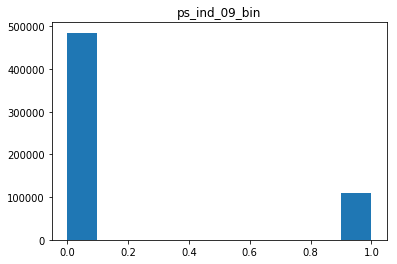

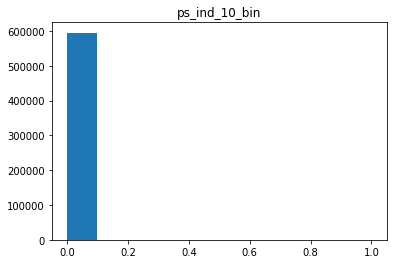

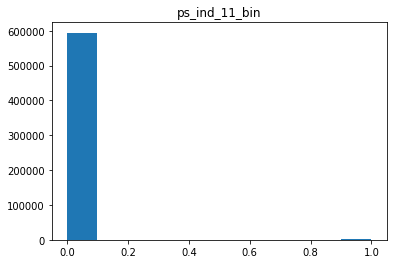

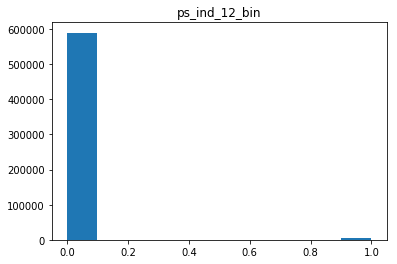

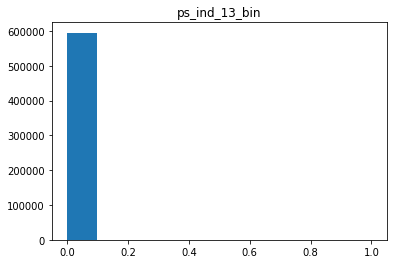

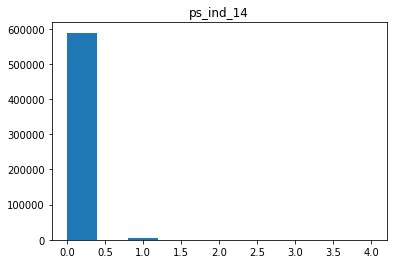

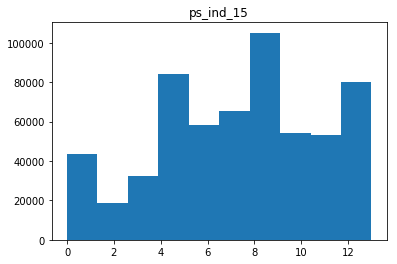

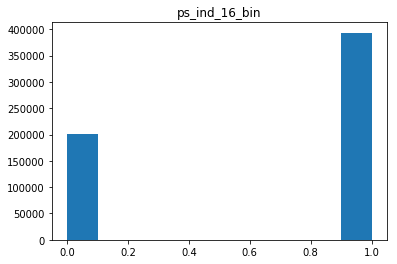

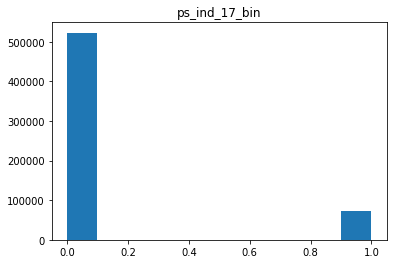

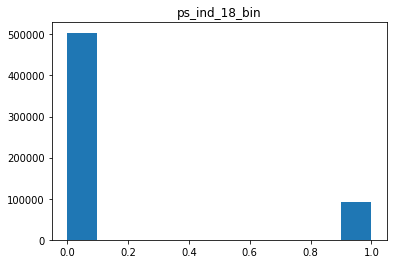

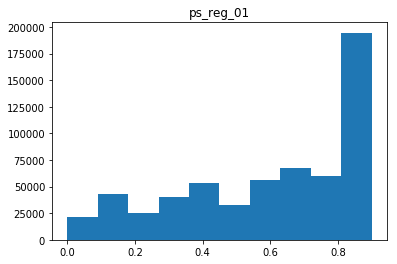

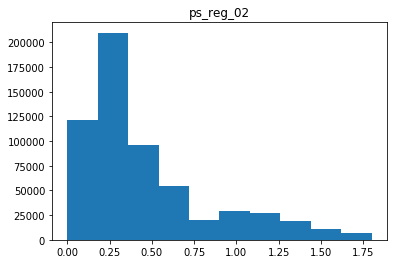

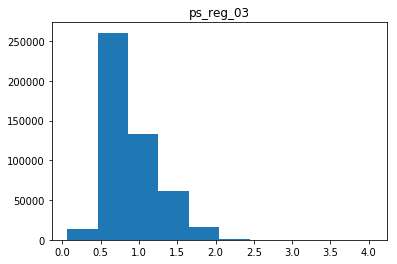

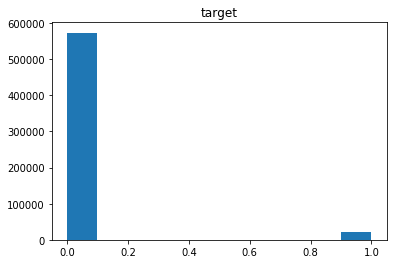

In [30]:
for col in sorted(train.columns):
    try:
        plt.hist(train[col].dropna(axis=0,how='all'))
        plt.title(col)
        plt.show()
    except Exception as e:
        print(e)

In [ ]:
plt.bar(train.)

O que podemos ver?

- As classes de previsão estão muito desbalanceadas
- Alto viés para o 0 (se chutar tudo 0 pode acertar bastante)
- Devemos ter alguma ponderação para balancear as classes na hora de treinar

Podemos ver que:
- ps_calc_* não estão relacionadas com a classe desejada
- Podemos removê-las para evitar curse of dimensionality

In [31]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [32]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)  

Como lidar com classes desbalanceadas?

Stratified Kfold !

Stratified KFold é utilizada para manter a distribuição de cada label consistente entre cada batch de treinamento.


In [33]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [34]:
# More parameters has to be tuned. Good luck :)
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

Treinamento

In [35]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [36]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [ ]:
%time
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
[Fold 1/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.039399	valid-gini:0.047171
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.323525	valid-gini:0.266151
